In [1]:
import re
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, train_test_split

In [91]:
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv')
df_graze = pd.read_csv('../data/ground/grazing/CARM_ActualGrazingInfov4_2013-2023.csv')

In [92]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Prep data

In [93]:
df_fq = df_fq.drop(columns=['Concatenate', 'Herd', 'Pasture Name',
       'Rotation', r"Tag #'s", 'Notes',
       'Ecological Site', 'HerdTreat', 'Phase'])

In [94]:
df_fq = df_fq.groupby(['Year', 'PastureID', 'Treatment', 'Date', 'Week']).mean().reset_index()

In [95]:
df_fq = df_fq.rename(columns={'Crude Protein (%)': 'CP',
                              'DOM(%)': 'DOM',
                              'Treatment': 'Treatment_full'})

In [96]:
treatment_rename_dict = {
    'CARM1': 'CARM',
    'CARM2': 'CARM',
    'Paired TRM1': 'TRM',
    'Paired TRM2': 'TRM',
    'CARM77': 'CARM',
    'CARM107': 'CARM'
    
}
pasture_rename_dict = {
    'NH': '10S'
}

In [97]:
df_fq['Treatment'] = df_fq['Treatment_full'].apply(lambda x: treatment_rename_dict[x] if x in treatment_rename_dict.keys() else x)

In [98]:
df_graze['corr_fact'] = df_graze['comments'].apply(lambda x: 0.5 if 'fence open' in str(x) else 1.0)
df_graze['NumSteers_corr']= df_graze['NumSteers'] * df_graze['corr_fact']

In [99]:
df_graze['PastureID'] = df_graze['PastureCode'].apply(lambda x: pasture_rename_dict[x] if x in pasture_rename_dict.keys() else x)

In [100]:
df_fq = pd.merge(df_fq, df_graze[['PastureID', 'Year', 'NumSteers_corr']],
                 how='left', on=['PastureID', 'Year'])

In [101]:
df_fq['period'] = np.ceil(df_fq['Week']/4).astype(int)
feature_names = ['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry', 'NumSteers_corr']

In [102]:
df_sub = df_fq[~df_fq['DOM'].isna()].copy()
df_sub = df_sub[~df_sub['CP'].isna()].copy()
#df_sub = df_sub[df_sub['Treatment'] == 'TRM'].copy()

<Axes: >

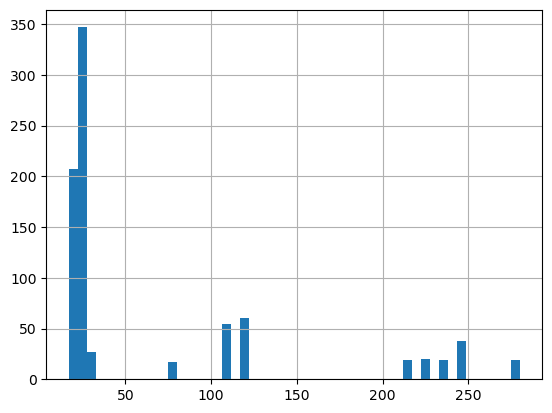

In [103]:
df_sub['NumSteers_corr'].hist(bins=50)

In [ ]:
rand_st = 2313
df_train, df_test = train_test_split(df_sub, test_size=0.2, stratify=df_sub['Treatment'], random_state=rand_st)

In [132]:
df_train = df_train[df_train['Treatment'] == 'TRM'].copy()
df_sub = df_sub[df_sub['Treatment'] == 'TRM'].copy()

In [105]:
display(df_train['Treatment'].value_counts())
display(df_test['Treatment'].value_counts())

Treatment
TRM    464
Name: count, dtype: int64

Treatment
TRM     117
CARM     49
Name: count, dtype: int64

<Axes: >

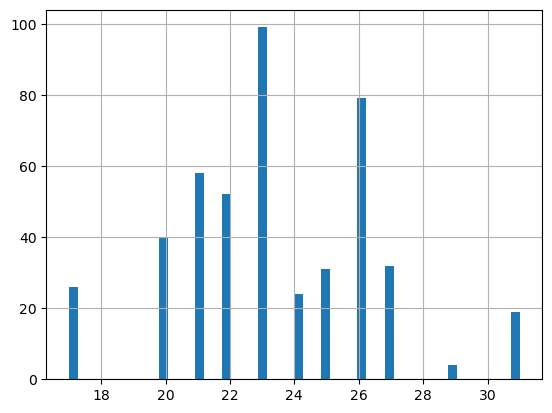

In [106]:
df_train['NumSteers_corr'].hist(bins=50)

<Axes: >

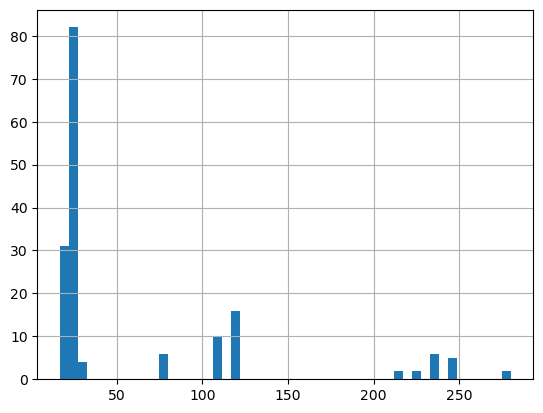

In [107]:
df_test['NumSteers_corr'].hist(bins=50)

# Prep RF model

In [108]:
######
fq_features = df_train[feature_names]
cp_labels = df_train['CP']
dom_labels = df_train['DOM']
strata = df_train['period']
fq_features_test = df_test[feature_names]
cp_labels_test = df_test['CP']
dom_labels_test = df_test['DOM']

In [109]:
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}
param_grid = {
    'RF__min_samples_split': [0.001, 0.01, 0.10],
    'RF__n_estimators': [100, 250, 500, 750],
    'RF__max_samples': [0.1, 0.25, 0.5, 0.75, 0.90],
    'RF__max_features': [1, 2, 3, 4, 5, 6],
}

skf = StratifiedKFold(n_splits=10, random_state=rand_st, shuffle=True)

# Create a based model
rf_pipe = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_jobs=1))
                ])


# Fit with steer count

## Fit CP

In [110]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features, strata)
cp_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=skf_cv, n_jobs=-1, verbose=0)
# Fit the grid search to the data
cp_grid_search.fit(fq_features, cp_labels)
cp_results = cp_grid_search.cv_results_

In [111]:
cp_grid_search.best_params_

{'RF__max_features': 1,
 'RF__max_samples': 0.9,
 'RF__min_samples_split': 0.001,
 'RF__n_estimators': 750}

In [112]:
print('R^2-CV: ' + str(cp_results['mean_test_R2'][cp_results['rank_test_MSE'] == 1]))
print('R^2-CV std: ' + str(cp_results['std_test_R2'][cp_results['rank_test_MSE'] == 1]))
print('MSE-CV: ' + str(-1.0 * cp_results['mean_test_MSE'][cp_results['rank_test_MSE'] == 1]))
print('MSE-CV std: ' + str(cp_results['std_test_MSE'][cp_results['rank_test_MSE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[cp_results['rank_test_MSE'] == 1] for
             key, value in cp_results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[cp_results['rank_test_MSE'] == 1] for
             key, value in cp_results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.74263769]
R^2-CV std: [0.03704722]
MSE-CV: [1.25249182]
MSE-CV std: [0.26419867]
RMSE-CV: 0.4590671365333606
RMSE-CV std: 0.005436804546053649


In [113]:
df_results_cp = pd.DataFrame({k:cp_results[k] for k in cp_results.keys() if not k.startswith('split')})
df_results_cp.loc[df_results_cp['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_cp['param_RF__max_samples'] = df_results_cp['param_RF__max_samples'].astype(str)

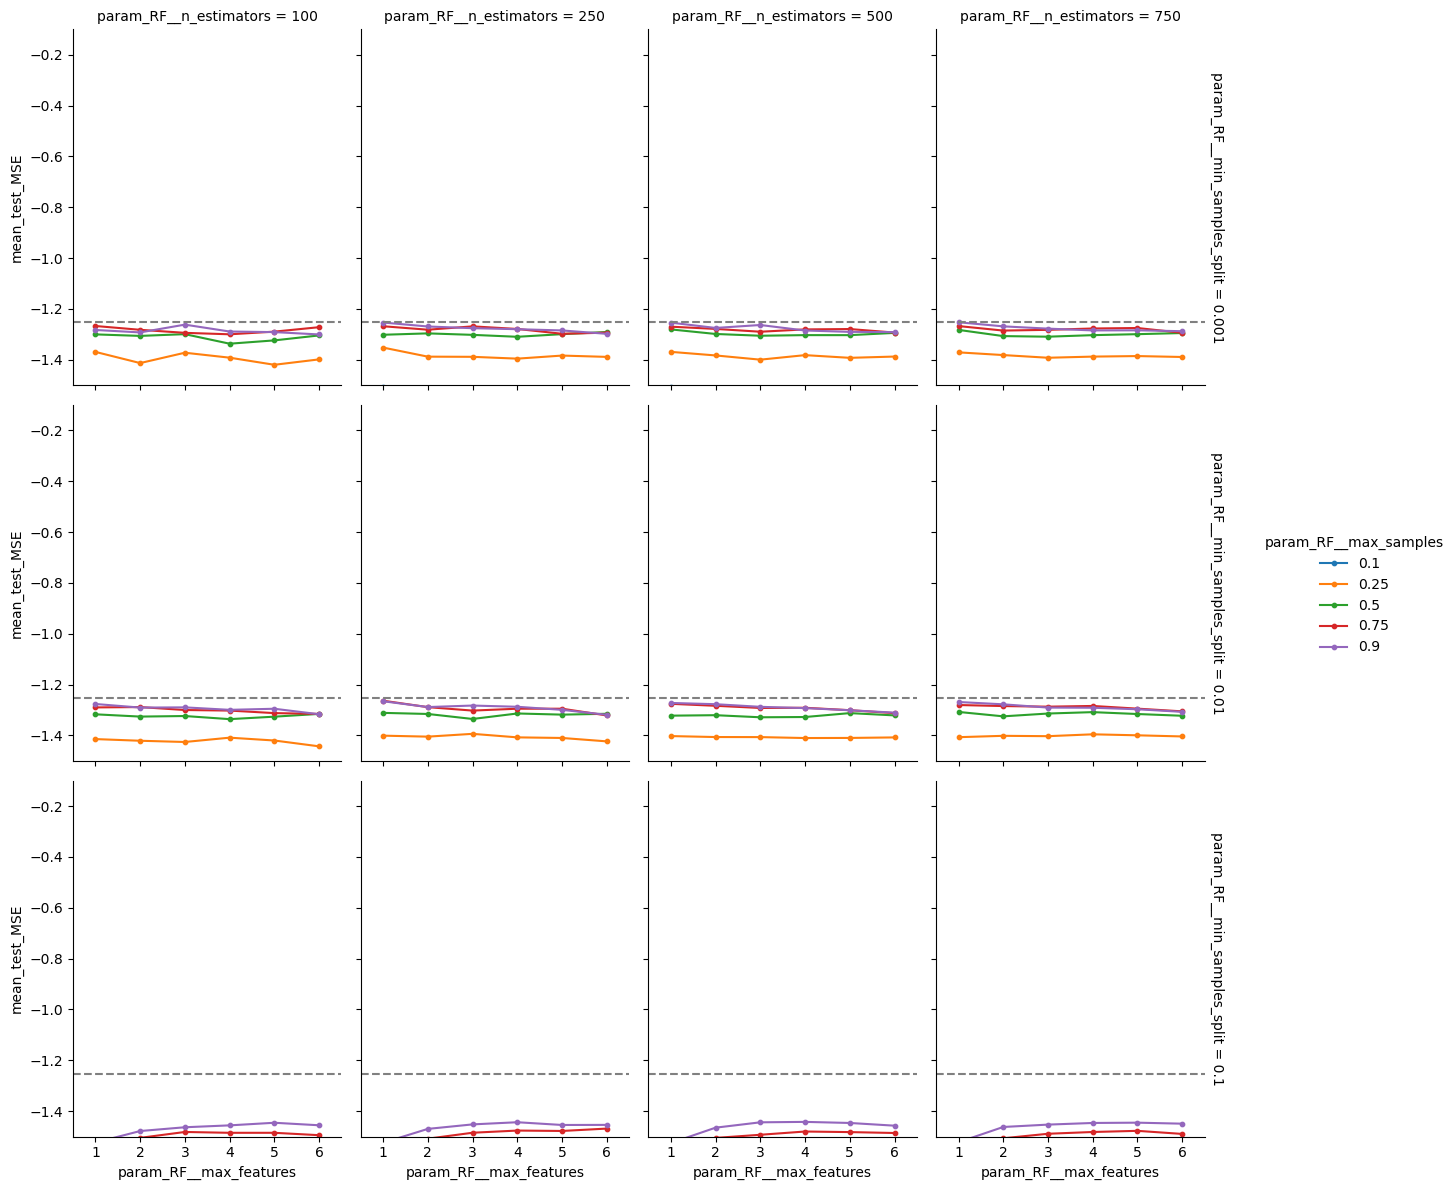

In [114]:
p = sns.FacetGrid(data=df_results_cp,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
#p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((-1.5, -0.1))
    ax.axhline(y=df_results_cp['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

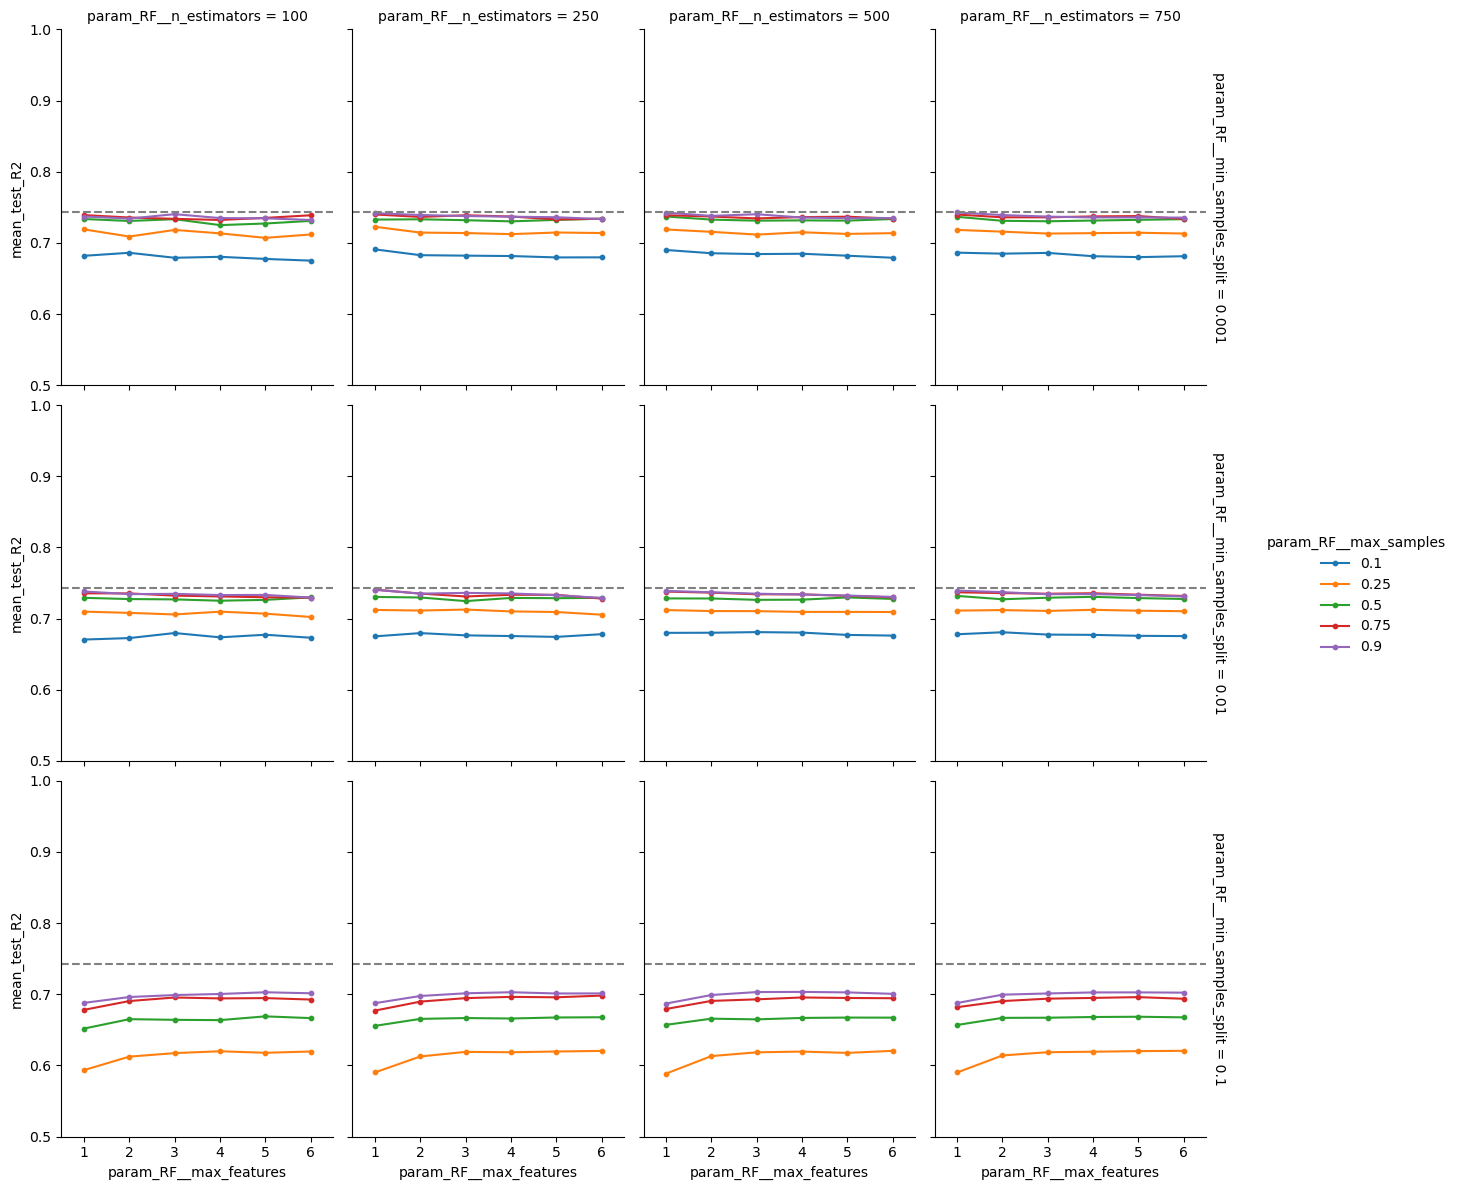

In [115]:
p = sns.FacetGrid(data=df_results_cp,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
#p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((0.5, 1.0))
    ax.axhline(y=df_results_cp['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [116]:
use_best = True
if use_best:
    cp_max_features = cp_grid_search.best_params_['RF__max_features']
    cp_n_estimators = cp_grid_search.best_params_['RF__n_estimators']
    cp_min_samples_split = cp_grid_search.best_params_['RF__min_samples_split']
    cp_max_samples = cp_grid_search.best_params_['RF__max_samples']
else:
    cp_max_features = 3
    cp_n_estimators = 750
    cp_min_samples_split = 0.001
    cp_max_samples = 0.9
    
    best_result_manual_cp = df_results_cp[(df_results_cp['param_RF__max_features'] == cp_max_features) &
    (df_results_cp['param_RF__n_estimators'] == cp_n_estimators) &
    (df_results_cp['param_RF__min_samples_split'] == cp_min_samples_split) &
    (df_results_cp['param_RF__max_samples'] == str(cp_max_samples))]
    display(best_result_manual_cp.drop(columns=['params']))

    print('R^2-CV: ' + str(results_cp['mean_test_R2'][results_cp['rank_test_MSE'] == 2]))
    print('R^2-CV std: ' + str(results_cp['std_test_R2'][results_cp['rank_test_MSE'] == 2]))
    print('MSE-CV: ' + str(-1.0 * results_cp['mean_test_MSE'][results_cp['rank_test_MSE'] == 2]))
    print('MSE-CV std: ' + str(results_cp['std_test_MSE'][results_cp['rank_test_MSE'] == 2]))
    print('RMSE-CV: ' + str(np.mean(
        np.sqrt([-1.0 * value[results_cp['rank_test_MSE'] == 2] for
                 key, value in results_cp.items() if re.search('split+\d_train_MSE', key)]))))
    print('RMSE-CV std: ' + str(np.std(
        np.sqrt([-1.0 * value[results_cp['rank_test_MSE'] == 2] for
                 key, value in results_cp.items() if re.search('split+\d_train_MSE', key)]))))

In [117]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators,
                                                 max_features=cp_max_features, 
                                                 min_samples_split=cp_min_samples_split, 
                                                 max_samples=cp_max_samples,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(fq_features, cp_labels)

# Use the forest's predict method on the test data
pred_cp = rf_cp_fnl.predict(fq_features)
pred_cp_test = rf_cp_fnl.predict(fq_features_test)
# Calculate the absolute errors_cp
errors_cp = np.mean((pred_cp - cp_labels)**2)
errors_cp_test = np.mean((pred_cp_test - cp_labels_test)**2)
# Print out the mean absolute error (mae)
print('RMSE Train:', round(np.sqrt(np.mean(errors_cp)), 2))
print('RMSE Test:', round(np.sqrt(np.mean(errors_cp_test)), 2))
#plt.figure()
#plt.scatter(pred_cp, cp_labels)
#abline(1, 0)

RMSE Train: 0.45
RMSE Test: 1.26


## Fit DOM

In [118]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features, strata)
dom_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=skf_cv, n_jobs=-1, verbose=0)

# Fit the grid search to the data
dom_grid_search.fit(fq_features, dom_labels)
dom_results = dom_grid_search.cv_results_

In [119]:
dom_grid_search.best_params_

{'RF__max_features': 1,
 'RF__max_samples': 0.75,
 'RF__min_samples_split': 0.001,
 'RF__n_estimators': 500}

In [120]:
print('R^2-CV: ' + str(dom_results['mean_test_R2'][dom_results['rank_test_MSE'] == 1]))
print('R^2-CV std: ' + str(dom_results['std_test_R2'][dom_results['rank_test_MSE'] == 1]))
print('MSE-CV: ' + str(-1.0 * dom_results['mean_test_MSE'][dom_results['rank_test_MSE'] == 1]))
print('MSE-CV std: ' + str(dom_results['std_test_MSE'][dom_results['rank_test_MSE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[dom_results['rank_test_MSE'] == 1] for
             key, value in dom_results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[dom_results['rank_test_MSE'] == 1] for
             key, value in dom_results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.66744112]
R^2-CV std: [0.08204949]
MSE-CV: [2.39720403]
MSE-CV std: [0.28370989]
RMSE-CV: 0.73749001383983
RMSE-CV std: 0.003900554972814538


In [121]:
df_results_dom = pd.DataFrame({k:dom_results[k] for k in dom_results.keys() if not k.startswith('split')})
df_results_dom.loc[df_results_dom['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'
df_results_dom['param_RF__max_samples'] = df_results_dom['param_RF__max_samples'].astype(str)

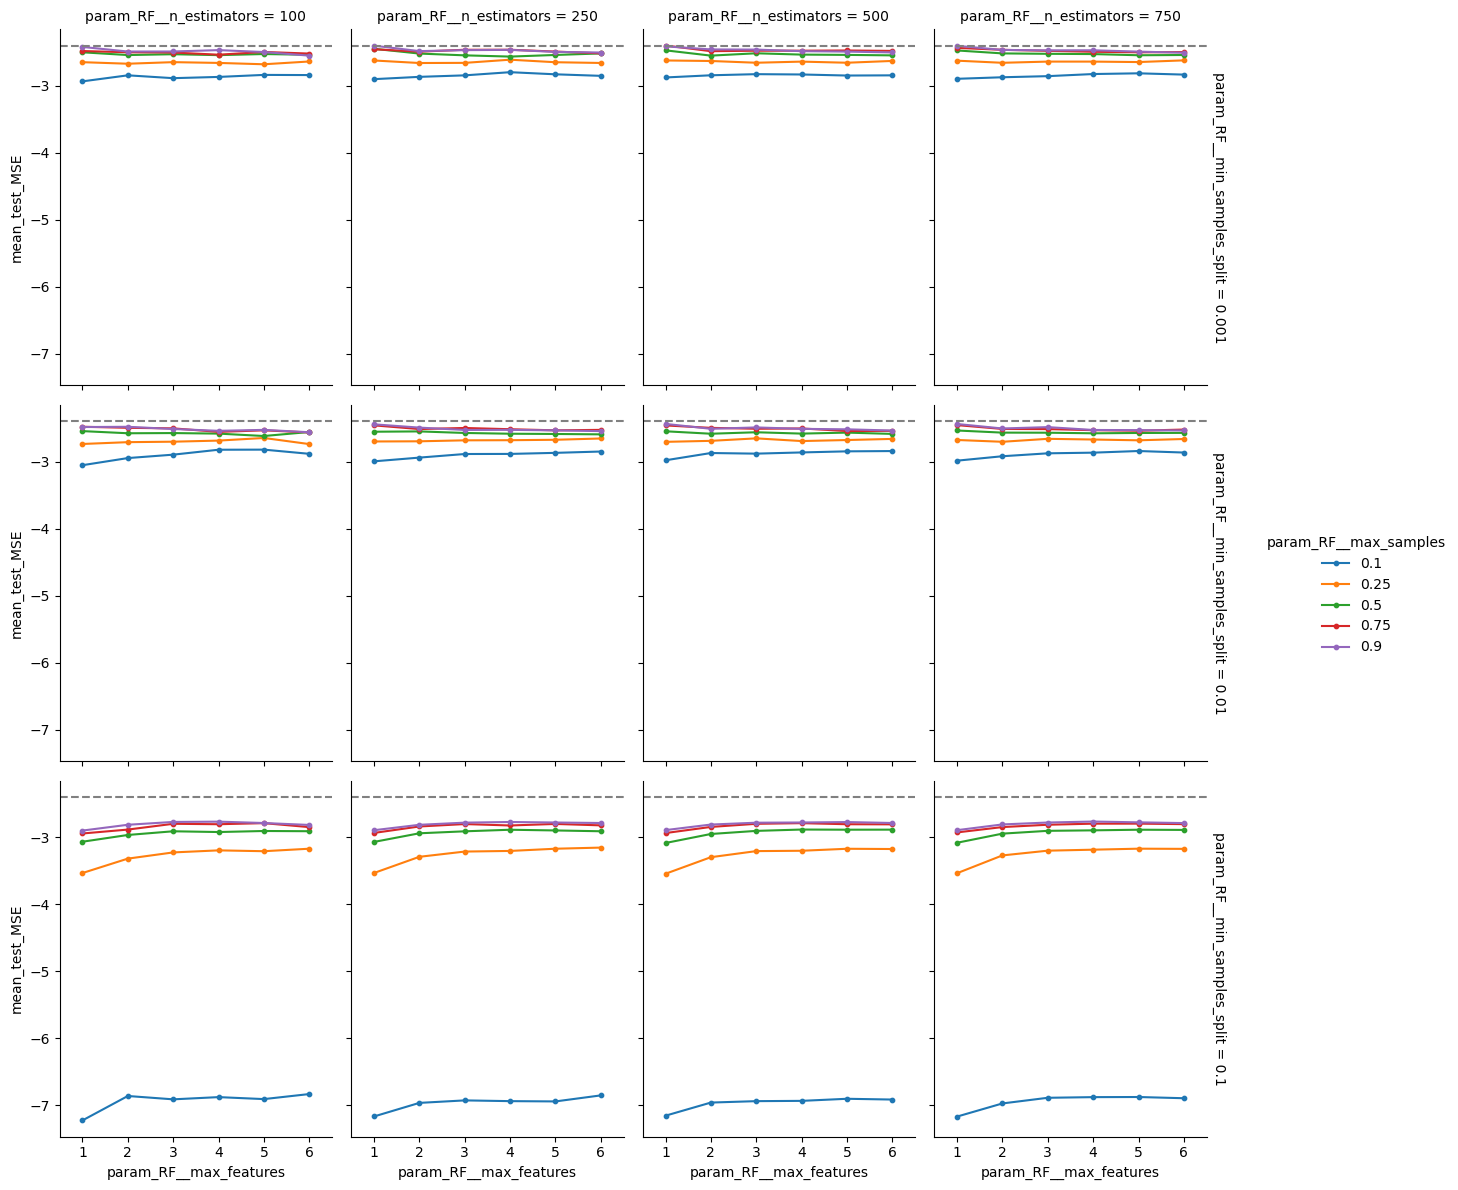

In [122]:
p = sns.FacetGrid(data=df_results_dom,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
#p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    #ax.set_ylim((-1.5, -0.1))
    ax.axhline(y=df_results_dom['mean_test_MSE'].max(), color='grey', linestyle='dashed')
p.add_legend()

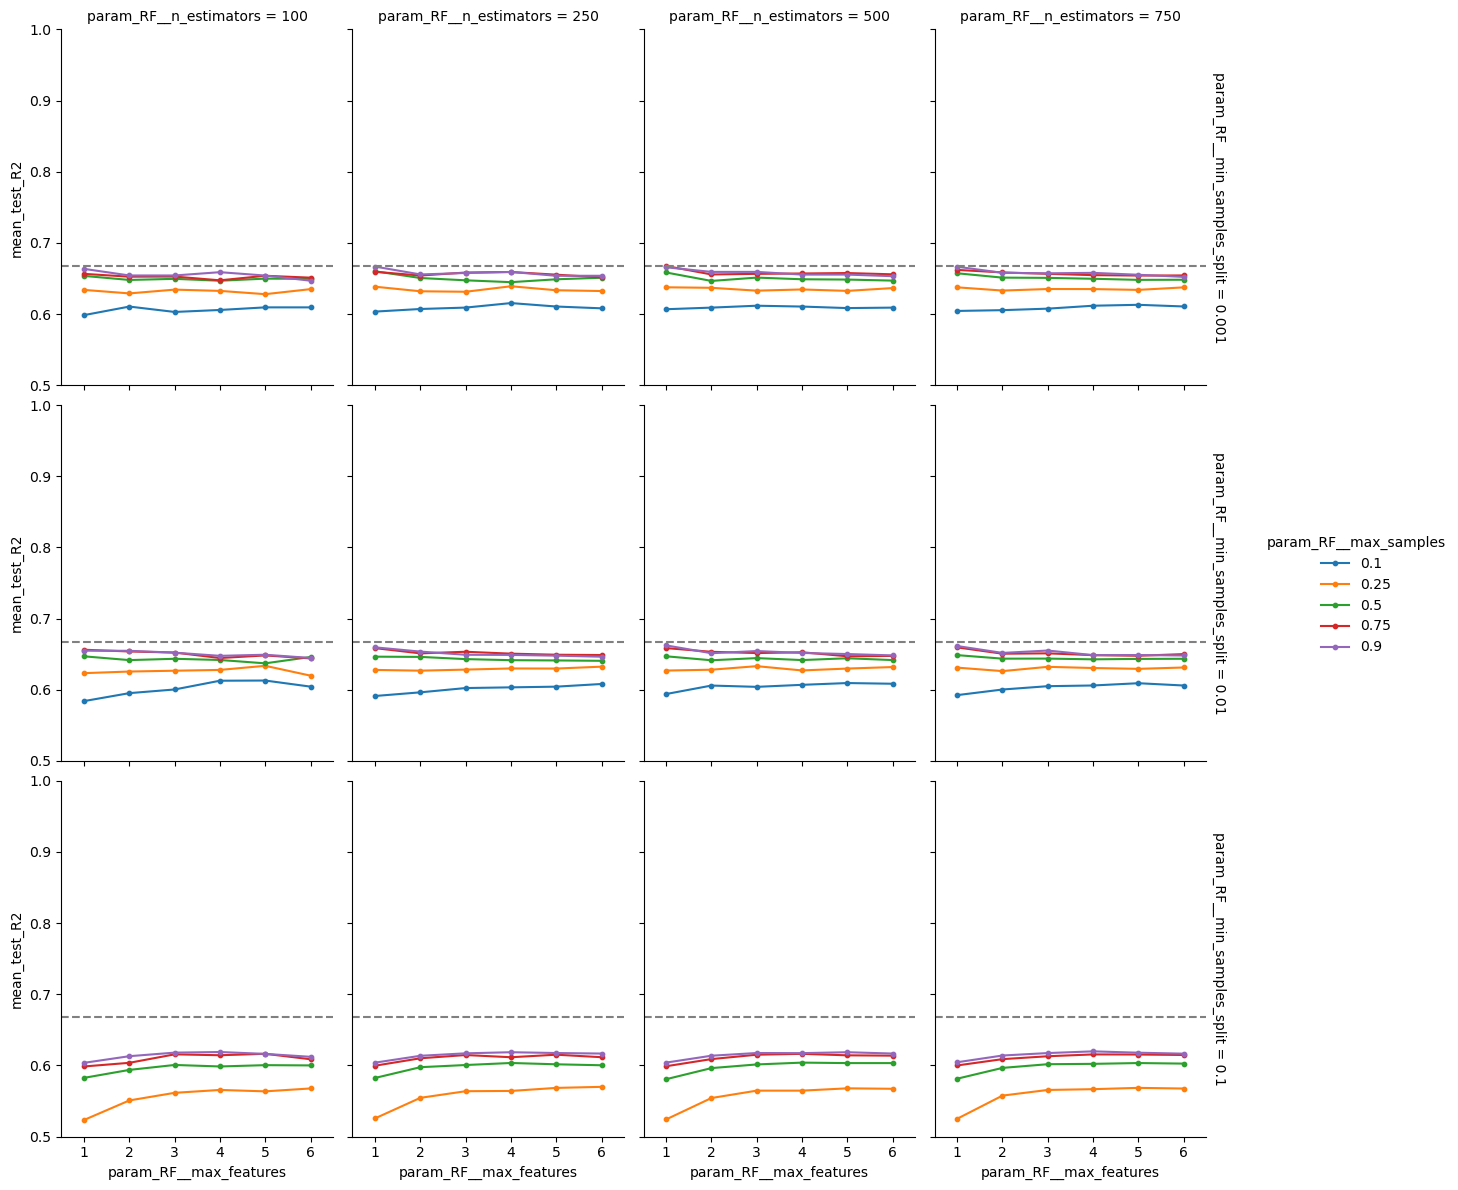

In [123]:
p = sns.FacetGrid(data=df_results_dom,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
#p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((0.5, 1.0))
    ax.axhline(y=df_results_dom['mean_test_R2'].max(), color='grey', linestyle='dashed')

p.add_legend()

In [124]:
use_best = True
if use_best:
    dom_max_features = dom_grid_search.best_params_['RF__max_features']
    dom_n_estimators = dom_grid_search.best_params_['RF__n_estimators']
    dom_min_samples_split = dom_grid_search.best_params_['RF__min_samples_split']
    dom_max_samples = dom_grid_search.best_params_['RF__max_samples']
else:
    dom_max_features = 3
    dom_n_estimators = 750
    dom_min_samples_split = 0.001
    dom_max_samples = 0.9
    
    best_result_manual_dom = df_results_dom[(df_results_dom['param_RF__max_features'] == dom_max_features) &
    (df_results_dom['param_RF__n_estimators'] == dom_n_estimators) &
    (df_results_dom['param_RF__min_samples_split'] == dom_min_samples_split) &
    (df_results_dom['param_RF__max_samples'] == str(dom_max_samples))]
    display(best_result_manual_dom.drop(columns=['params']))

    print('R^2-CV: ' + str(results_dom['mean_test_R2'][results_dom['rank_test_MSE'] == 2]))
    print('R^2-CV std: ' + str(results_dom['std_test_R2'][results_dom['rank_test_MSE'] == 2]))
    print('MSE-CV: ' + str(-1.0 * results_dom['mean_test_MSE'][results_dom['rank_test_MSE'] == 2]))
    print('MSE-CV std: ' + str(results_dom['std_test_MSE'][results_dom['rank_test_MSE'] == 2]))
    print('RMSE-CV: ' + str(np.mean(
        np.sqrt([-1.0 * value[results_dom['rank_test_MSE'] == 2] for
                 key, value in results_dom.items() if re.search('split+\d_train_MSE', key)]))))
    print('RMSE-CV std: ' + str(np.std(
        np.sqrt([-1.0 * value[results_dom['rank_test_MSE'] == 2] for
                 key, value in results_dom.items() if re.search('split+\d_train_MSE', key)]))))

In [125]:
# Create a based model
rf_dom_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators,
                                                 max_features=dom_max_features, 
                                                 min_samples_split=dom_min_samples_split, 
                                                 max_samples=dom_max_samples,
                                                 n_jobs=-1))
                ])
rf_dom_fnl.fit(fq_features, dom_labels)

# Use the forest's predict method on the test data
pred_dom = rf_dom_fnl.predict(fq_features)
pred_dom_test = rf_dom_fnl.predict(fq_features_test)
# Calculate the absolute errors_dom
errors_dom = np.mean((pred_dom - dom_labels)**2)
errors_dom_test = np.mean((pred_dom_test - dom_labels_test)**2)
# Print out the mean absolute error (mae)
print('RMSE Train:', round(np.sqrt(np.mean(errors_dom)), 2))
print('RMSE Test:', round(np.sqrt(np.mean(errors_dom_test)), 2))
#plt.figure()
#plt.scatter(pred_dom, dom_labels)
#abline(1, 0)

RMSE Train: 0.73
RMSE Test: 1.86


# Fit without steer count

In [126]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata)
cp_grid_search_ns = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=skf_cv, n_jobs=-1, verbose=0)
# Fit the grid search to the data
cp_grid_search_ns.fit(fq_features, cp_labels)
cp_results_ns = cp_grid_search_ns.cv_results_

cp_max_features_ns = cp_grid_search_ns.best_params_['RF__max_features']
cp_n_estimators_ns = cp_grid_search_ns.best_params_['RF__n_estimators']
cp_min_samples_split_ns = cp_grid_search_ns.best_params_['RF__min_samples_split']
cp_max_samples_ns = cp_grid_search_ns.best_params_['RF__max_samples']

# Create a based model
rf_cp_fnl_ns = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators_ns,
                                                 max_features=cp_max_features_ns, 
                                                 min_samples_split=cp_min_samples_split_ns, 
                                                 max_samples=cp_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_cp_fnl_ns.fit(fq_features.drop(columns='NumSteers_corr'), cp_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.9,
                                       min_samples_split=0.001,
                                       n_estimators=750, n_jobs=-1))])

In [127]:
# Instantiate the grid search model
skf_cv = skf.split(fq_features.drop(columns='NumSteers_corr'), strata)
dom_grid_search_ns = GridSearchCV(estimator=rf_pipe, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=skf_cv, n_jobs=-1, verbose=0)
# Fit the grid search to the data
dom_grid_search_ns.fit(fq_features, dom_labels)
dom_results_ns = dom_grid_search_ns.cv_results_

dom_max_features_ns = dom_grid_search_ns.best_params_['RF__max_features']
dom_n_estimators_ns = dom_grid_search_ns.best_params_['RF__n_estimators']
dom_min_samples_split_ns = dom_grid_search_ns.best_params_['RF__min_samples_split']
dom_max_samples_ns = dom_grid_search_ns.best_params_['RF__max_samples']

# Create a based model
rf_dom_fnl_ns = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators_ns,
                                                 max_features=dom_max_features_ns, 
                                                 min_samples_split=dom_min_samples_split_ns, 
                                                 max_samples=dom_max_samples_ns,
                                                 n_jobs=-1))
                ])
rf_dom_fnl_ns.fit(fq_features.drop(columns='NumSteers_corr'), dom_labels)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.9,
                                       min_samples_split=0.001,
                                       n_estimators=500, n_jobs=-1))])

# Plot results

In [128]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
def corrfunc(x, y, **kwargs):
    data = kwargs.pop('data')
    r, _ = stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

In [129]:
df_test['CP_pred'] = rf_cp_fnl.predict(df_test[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry', 'NumSteers_corr']])
df_test['DOM_pred'] = rf_dom_fnl.predict(df_test[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry', 'NumSteers_corr']])
df_test['CP_pred_ns'] = rf_cp_fnl_ns.predict(df_test[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']])
df_test['DOM_pred_ns'] = rf_dom_fnl_ns.predict(df_test[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']])

In [130]:
r2_trm_cp = r2_score(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'TRM'])
r_trm_cp, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'TRM'])
bias_trm_cp = np.mean(df_test['CP_pred'][df_test['Treatment'] == 'TRM'] - df_test['CP'][df_test['Treatment'] == 'TRM'])

r2_trm_cp_ns = r2_score(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'])
r_trm_cp_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'])
bias_trm_cp_ns = np.mean(df_test['CP_pred_ns'][df_test['Treatment'] == 'TRM'] - df_test['CP'][df_test['Treatment'] == 'TRM'])

r2_carm_cp = r2_score(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'CARM'])
r_carm_cp, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred'][df_test['Treatment'] == 'CARM'])
bias_carm_cp = np.mean(df_test['CP_pred'][df_test['Treatment'] == 'CARM'] - df_test['CP'][df_test['Treatment'] == 'CARM'])

r2_carm_cp_ns = r2_score(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'])
r_carm_cp_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'CARM'], 
                     df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'])
bias_carm_cp_ns = np.mean(df_test['CP_pred_ns'][df_test['Treatment'] == 'CARM'] - df_test['CP'][df_test['Treatment'] == 'CARM'])

r2_trm_dom = r2_score(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'TRM'])
r_trm_dom, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'TRM'])
bias_trm_dom = np.mean(df_test['DOM_pred'][df_test['Treatment'] == 'TRM'] - df_test['DOM'][df_test['Treatment'] == 'TRM'])

r2_trm_dom_ns = r2_score(df_test['DOM'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'])
r_trm_dom_ns, _ = stats.pearsonr(df_test['CP'][df_test['Treatment'] == 'TRM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'])
bias_trm_dom_ns = np.mean(df_test['DOM_pred_ns'][df_test['Treatment'] == 'TRM'] - df_test['DOM'][df_test['Treatment'] == 'TRM'])

r2_carm_dom = r2_score(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'CARM'])
r_carm_dom, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred'][df_test['Treatment'] == 'CARM'])
bias_carm_dom = np.mean(df_test['DOM_pred'][df_test['Treatment'] == 'CARM'] - df_test['DOM'][df_test['Treatment'] == 'CARM'])

r2_carm_dom_ns = r2_score(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'])
r_carm_dom_ns, _ = stats.pearsonr(df_test['DOM'][df_test['Treatment'] == 'CARM'], 
                     df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'])
bias_carm_dom_ns = np.mean(df_test['DOM_pred_ns'][df_test['Treatment'] == 'CARM'] - df_test['DOM'][df_test['Treatment'] == 'CARM'])

Text(0, 0.5, '')

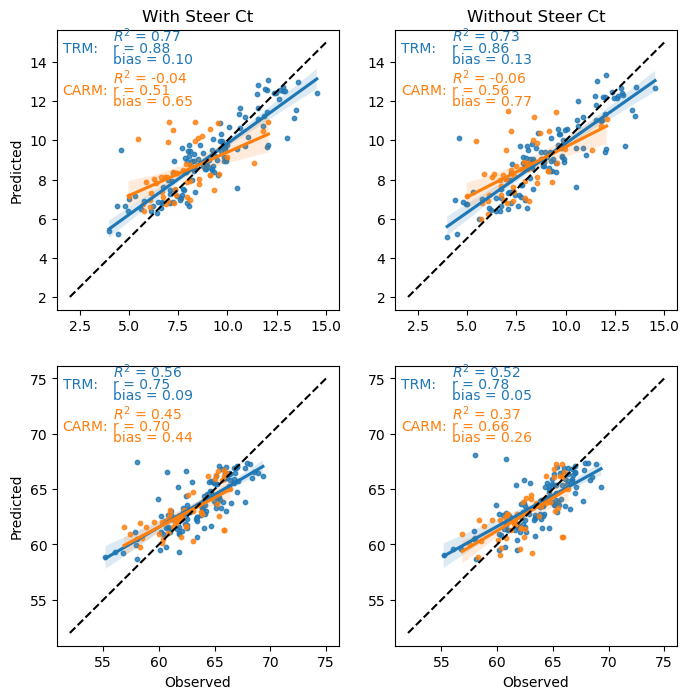

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.regplot(x='CP', y='CP_pred', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[0,0])
sns.regplot(x='CP', y='CP_pred', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[0,0])
axs[0,0].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[0,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_trm_cp),
                  xy=(.20, .96), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("r = {:.2f}".format(r_trm_cp),
                  xy=(.20, .92), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("bias = {:.2f}".format(bias_trm_cp),
                  xy=(.20, .88), xycoords=axs[0,0].transAxes, color='tab:blue')
axs[0,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("$R^2$ = {:.2f}".format(r2_carm_cp),
                  xy=(.20, .81), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("r = {:.2f}".format(r_carm_cp),
                  xy=(.20, .77), xycoords=axs[0,0].transAxes, color='tab:orange')
axs[0,0].annotate("bias = {:.2f}".format(bias_carm_cp),
                  xy=(.20, .73), xycoords=axs[0,0].transAxes, color='tab:orange')


sns.regplot(x='CP', y='CP_pred_ns', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[0,1])
sns.regplot(x='CP', y='CP_pred_ns', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[0,1])
axs[0,1].plot(np.arange(2, 16), np.arange(2, 16), color='black', linestyle='dashed')
axs[0,1].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("$R^2$ = {:.2f}".format(r2_trm_cp_ns),
                  xy=(.20, .96), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("r = {:.2f}".format(r_trm_cp_ns),
                  xy=(.20, .92), xycoords=axs[0,1].transAxes, color='tab:blue')
axs[0,1].annotate("bias = {:.2f}".format(bias_trm_cp_ns),
                  xy=(.20, .88), xycoords=axs[0,1].transAxes, color='tab:blue')

axs[0,1].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("$R^2$ = {:.2f}".format(r2_carm_cp_ns),
                  xy=(.20, .81), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("r = {:.2f}".format(r_carm_cp_ns),
                  xy=(.20, .77), xycoords=axs[0,1].transAxes, color='tab:orange')
axs[0,1].annotate("bias = {:.2f}".format(bias_carm_cp_ns),
                  xy=(.20, .73), xycoords=axs[0,1].transAxes, color='tab:orange')

sns.regplot(x='DOM', y='DOM_pred', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[1,0])
sns.regplot(x='DOM', y='DOM_pred', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[1,0])
axs[1,0].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')
axs[1,0].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_trm_dom),
                  xy=(.20, .96), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("r = {:.2f}".format(r_trm_dom),
                  xy=(.20, .92), xycoords=axs[1,0].transAxes, color='tab:blue')
axs[1,0].annotate("bias = {:.2f}".format(bias_trm_dom),
                  xy=(.20, .88), xycoords=axs[1,0].transAxes, color='tab:blue')

axs[1,0].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("$R^2$ = {:.2f}".format(r2_carm_dom),
                  xy=(.20, .81), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("r = {:.2f}".format(r_carm_dom),
                  xy=(.20, .77), xycoords=axs[1,0].transAxes, color='tab:orange')
axs[1,0].annotate("bias = {:.2f}".format(bias_carm_dom),
                  xy=(.20, .73), xycoords=axs[1,0].transAxes, color='tab:orange')

sns.regplot(x='DOM', y='DOM_pred_ns', data=df_test[df_test['Treatment'] == 'TRM'], 
            scatter_kws={'color': 'tab:blue', 's': 10},
            ax=axs[1,1])
sns.regplot(x='DOM', y='DOM_pred_ns', data=df_test[df_test['Treatment'] == 'CARM'], 
            scatter_kws={'color': 'tab:orange', 's': 10},
            ax=axs[1,1])
axs[1,1].plot(np.arange(52, 76), np.arange(52, 76), color='black', linestyle='dashed')
axs[1,1].annotate("TRM:",
                  xy=(.02, .92), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("$R^2$ = {:.2f}".format(r2_trm_dom_ns),
                  xy=(.20, .96), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("r = {:.2f}".format(r_trm_dom_ns),
                  xy=(.20, .92), xycoords=axs[1,1].transAxes, color='tab:blue')
axs[1,1].annotate("bias = {:.2f}".format(bias_trm_dom_ns),
                  xy=(.20, .88), xycoords=axs[1,1].transAxes, color='tab:blue')

axs[1,1].annotate("CARM:",
                  xy=(.02, .77), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("$R^2$ = {:.2f}".format(r2_carm_dom_ns),
                  xy=(.20, .81), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("r = {:.2f}".format(r_carm_dom_ns),
                  xy=(.20, .77), xycoords=axs[1,1].transAxes, color='tab:orange')
axs[1,1].annotate("bias = {:.2f}".format(bias_carm_dom_ns),
                  xy=(.20, .73), xycoords=axs[1,1].transAxes, color='tab:orange')

axs[0,0].set_title('With Steer Ct')
axs[0,1].set_title('Without Steer Ct')
axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,0].set_ylabel('')
axs[0,1].set_ylabel('')
axs[0,0].set_ylabel('Predicted')
axs[1,0].set_ylabel('Predicted')
axs[1,0].set_xlabel('Observed')
axs[1,1].set_xlabel('Observed')
axs[1,1].set_ylabel('')

# Fit final models without steer count

In [143]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=cp_n_estimators,
                                                 max_features=cp_max_features, 
                                                 min_samples_split=cp_min_samples_split, 
                                                 max_samples=cp_max_samples,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(df_sub[feature_names].drop(columns='NumSteers_corr'), df_sub['CP'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.9,
                                       min_samples_split=0.001,
                                       n_estimators=750, n_jobs=-1))])

In [144]:
# Create a based model
rf_dom_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=dom_n_estimators,
                                                 max_features=dom_max_features, 
                                                 min_samples_split=dom_min_samples_split, 
                                                 max_samples=dom_max_samples,
                                                 n_jobs=-1))
                ])
rf_dom_fnl.fit(df_sub[feature_names].drop(columns='NumSteers_corr'), df_sub['DOM'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.75,
                                       min_samples_split=0.001,
                                       n_estimators=500, n_jobs=-1))])

In [145]:
import pickle
pickle.dump(rf_cp_fnl, open('../models/diet_quality/rf_cp_ndvi_2014_2023.pkl', 'wb'))
pickle.dump(rf_dom_fnl, open('../models/diet_quality/rf_dom_ndvi_2014_2023.pkl', 'wb'))

In [136]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

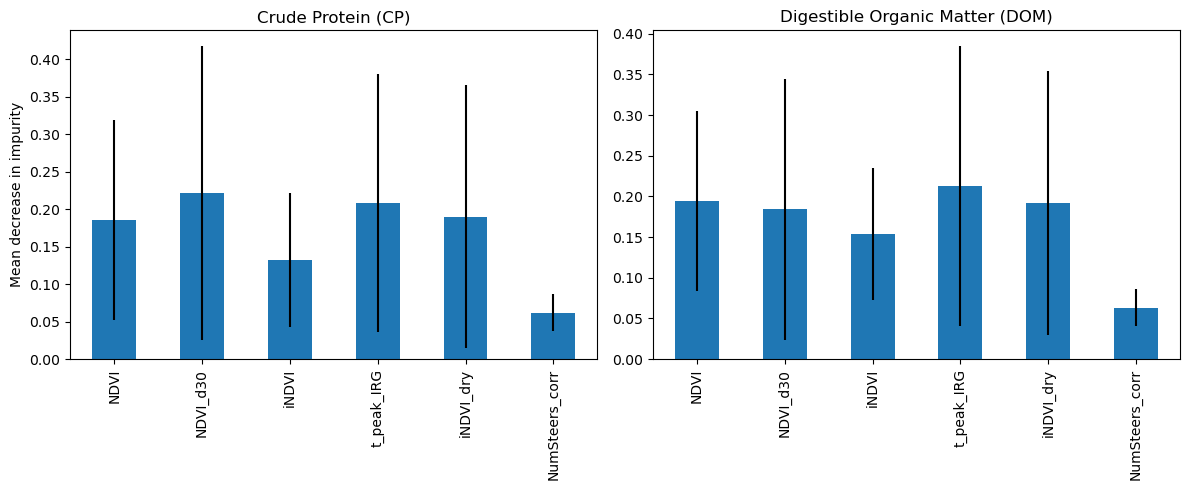

In [137]:
cp_importances = rf_cp_fnl.named_steps['RF'].feature_importances_
cp_importances_std = np.std([tree.feature_importances_ for tree in rf_cp_fnl.named_steps['RF'].estimators_], axis=0)
ps_cp_importances = pd.Series(cp_importances, index=feature_names)
dom_importances = rf_dom_fnl.named_steps['RF'].feature_importances_
dom_importances_std = np.std([tree.feature_importances_ for tree in rf_dom_fnl.named_steps['RF'].estimators_], axis=0)
ps_dom_importances = pd.Series(dom_importances, index=feature_names)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ps_cp_importances.plot.bar(yerr=cp_importances_std, ax=axs[0])
axs[0].set_title("Crude Protein (CP)")
ps_dom_importances.plot.bar(yerr=dom_importances_std, ax=axs[1])
axs[1].set_title("Digestible Organic Matter (DOM)")
axs[0].set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [138]:
########################################################
cp_levels = np.arange(6.5, 12.5, 0.5)
cp_grid_res = 20
cp_percentiles = [0, 1]
cp_lines = True
cp_labels = False
fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], wspace=0.20)
gs_leg = mpl.gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.3], top=0.85, bottom=0.10)

<Figure size 1000x1000 with 0 Axes>

TypeError: matplotlib.axes._axes.Axes.contourf() got multiple values for keyword argument 'levels'

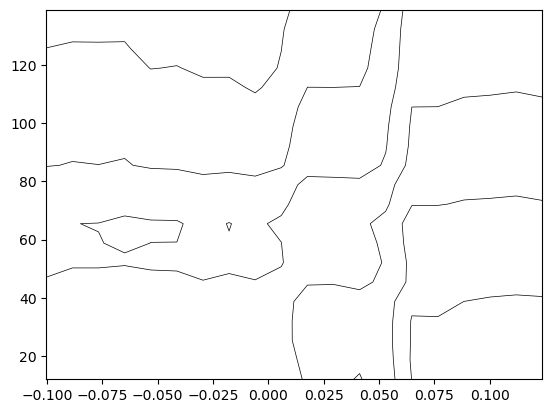

In [140]:
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                               df_sub[feature_names],
                                               [(1, 3)], 
                                               grid_resolution=cp_grid_res,
                                               #percentiles=(0,1), 
                                               contour_kw={'levels': cp_levels},
                                               n_jobs=-1)

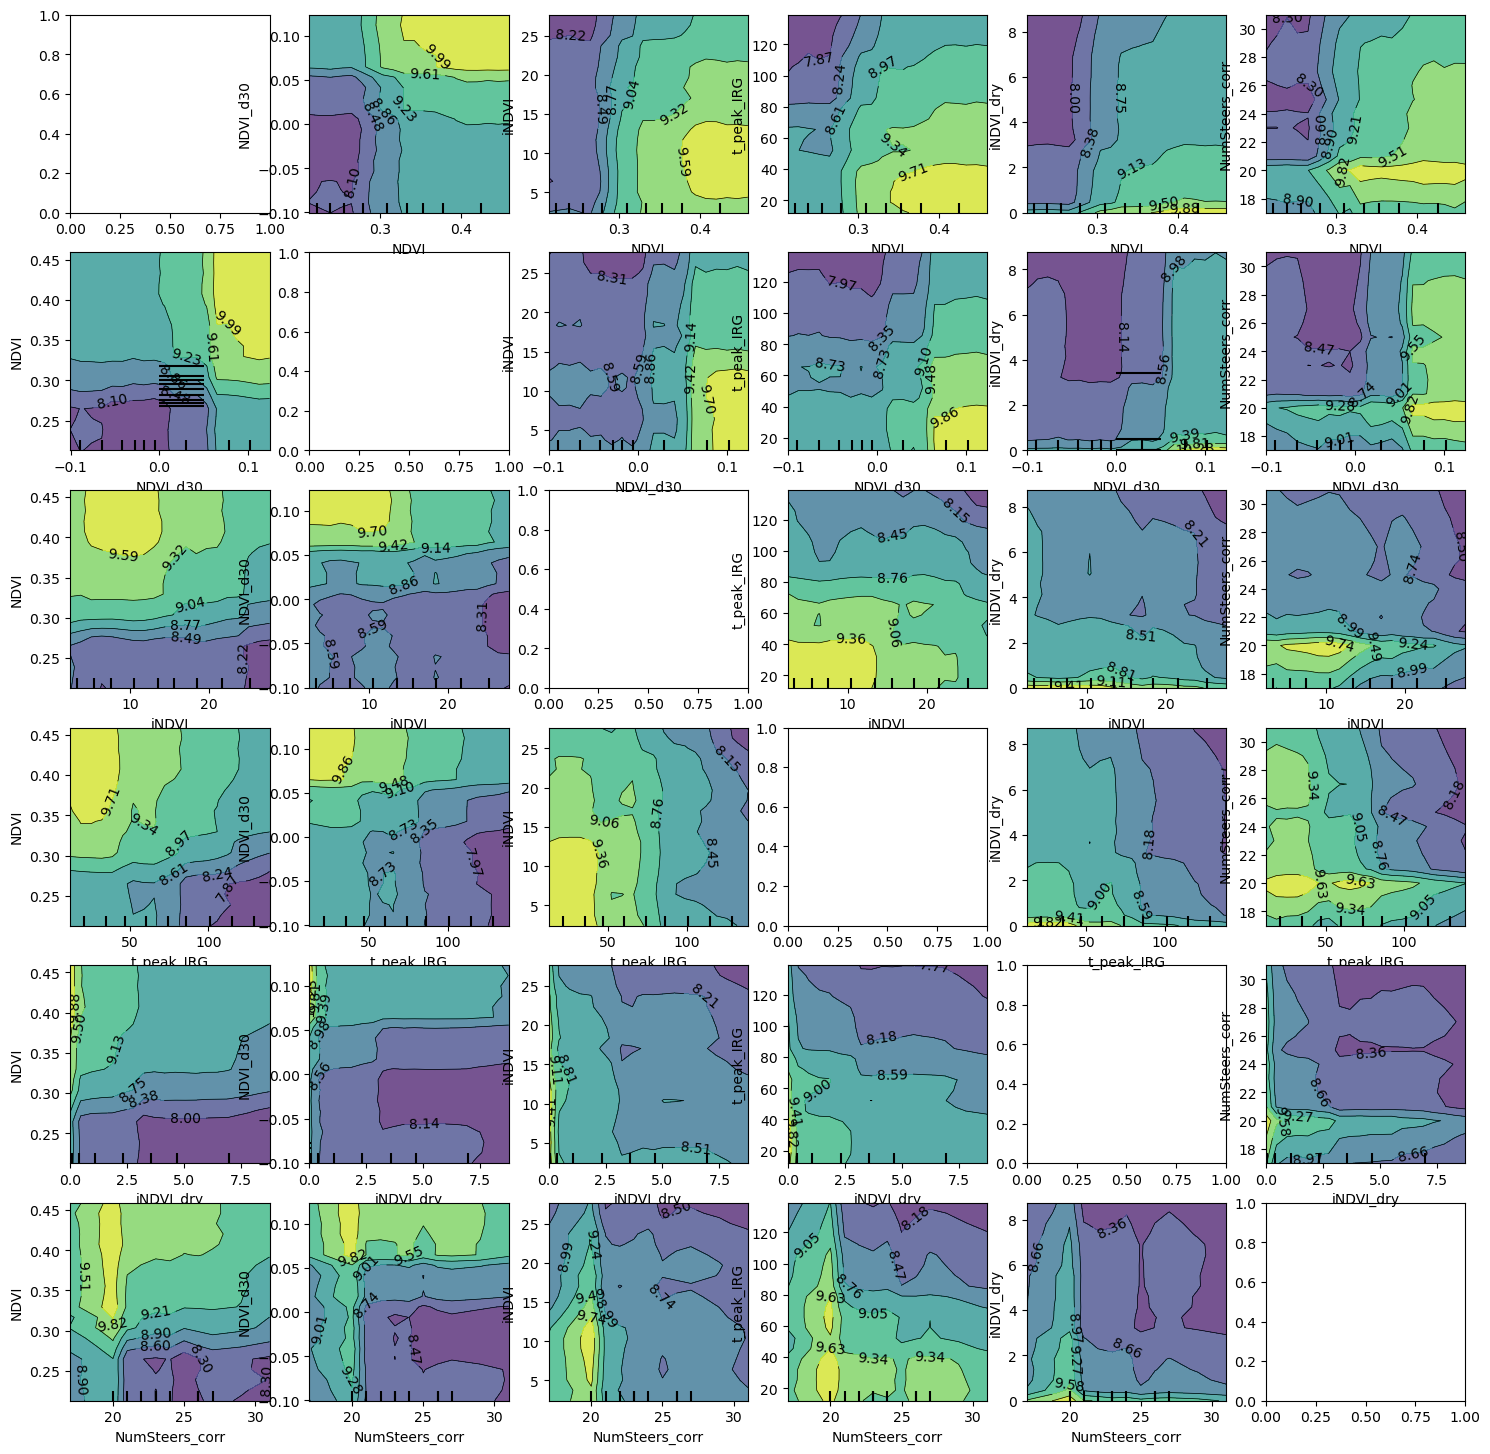

In [142]:
fig, axs = plt.subplots(nrows=len(feature_names), ncols=len(feature_names),
                        figsize=(18, 18), sharex=False, sharey=False)
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if i == j:
            continue
        else:
            PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                                    df_sub[feature_names],
                                                    [(i, j)], 
                                                    grid_resolution=cp_grid_res,
                                                    n_jobs=-1,
                                                    ax=axs[i,j])

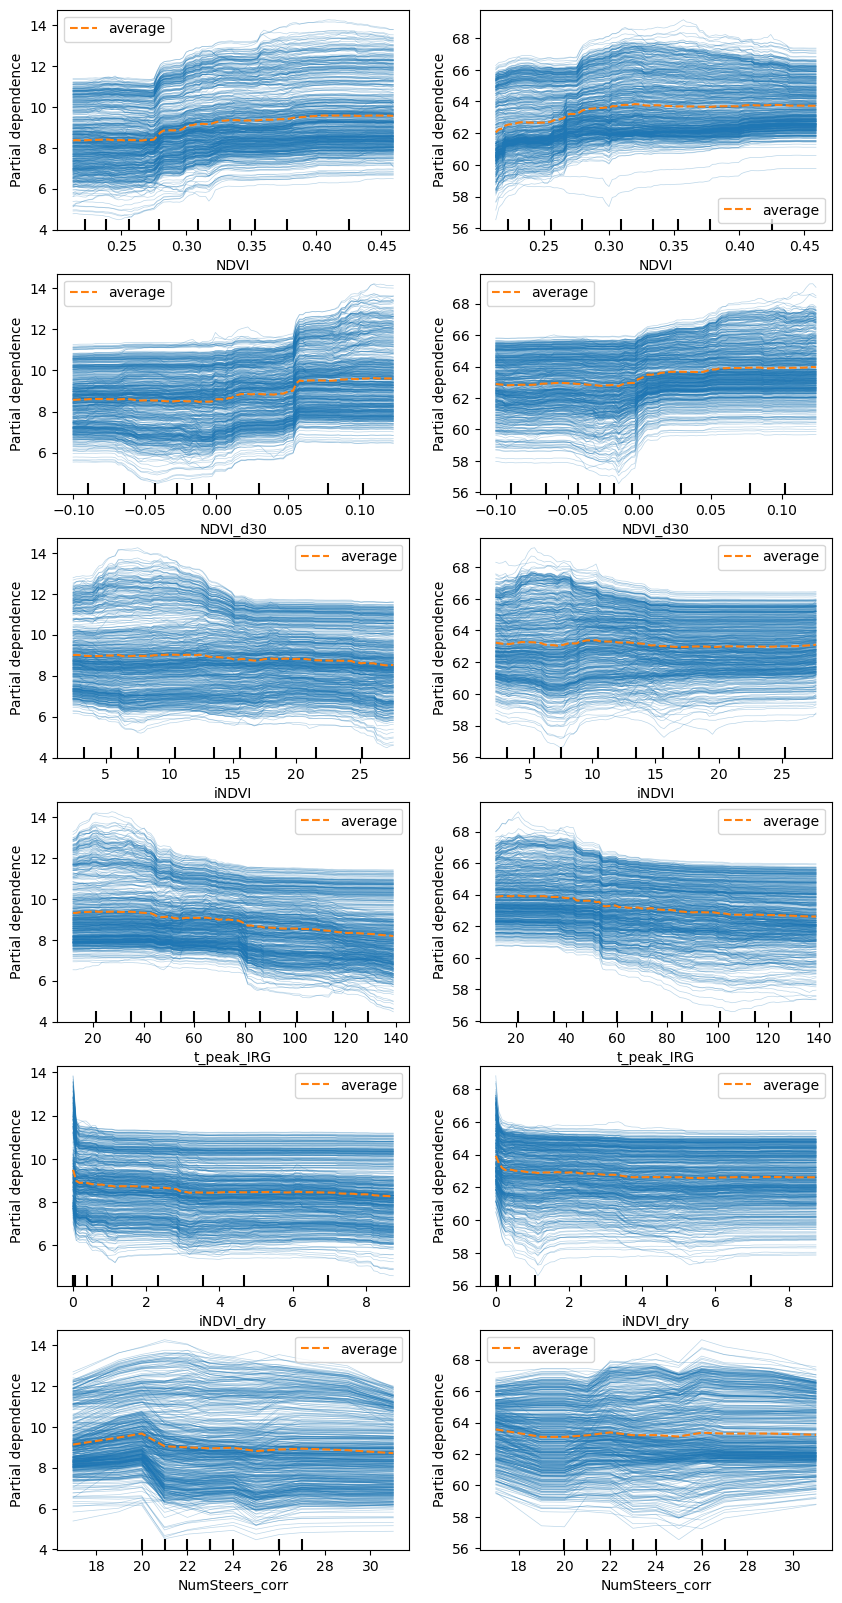

In [141]:
fig, axs = plt.subplots(nrows=len(feature_names), ncols=2, figsize=(10, 20), sharex=False)
for i in range(len(feature_names)):
    PartialDependenceDisplay.from_estimator(rf_cp_fnl,
                                            df_sub[feature_names],
                                            [i], 
                                            kind='both',
                                            ax=axs[i, 0],
                                            n_jobs=-1)
    PartialDependenceDisplay.from_estimator(rf_dom_fnl,
                                            df_sub[feature_names],
                                            [i], 
                                            kind='both',
                                            ax=axs[i, 1],
                                            n_jobs=-1)

In [75]:
ax1 = fig.add_subplot(gs[0, 0])
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(4, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax1,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax2 = fig.add_subplot(gs[0, 1])
pdp2 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax2,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp2.axes_[0][0].set_xlabel('')
pdp2.axes_[0][0].set_ylabel('')

ax3 = fig.add_subplot(gs[0, 2])
pdp3 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax3,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp3.axes_[0][0].set_xlabel('')
pdp3.axes_[0][0].set_ylabel('')

ax4 = fig.add_subplot(gs[0, 3])
pdp4 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax4,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp4.axes_[0][0].set_xlabel('')
pdp4.axes_[0][0].set_ylabel('')

ax5 = fig.add_subplot(gs[1, 1])
pdp5 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(1, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax5,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax6 = fig.add_subplot(gs[1, 2])
pdp6 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax6,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp6.axes_[0][0].set_xlabel('')
pdp6.axes_[0][0].set_ylabel('')

ax7 = fig.add_subplot(gs[1, 3])
pdp7 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax7,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp7.axes_[0][0].set_xlabel('')
pdp7.axes_[0][0].set_ylabel('')

ax8 = fig.add_subplot(gs[2, 2])
pdp8 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(3, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax8,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax9 = fig.add_subplot(gs[2, 3])
pdp9 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax9,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp9.axes_[0][0].set_xlabel('')
pdp9.axes_[0][0].set_ylabel('')

ax10 = fig.add_subplot(gs[3, 3])
pdp10 = PartialDependenceDisplay.from_estimator(rf_cp_fnl, cp_features,
                        [(0, 3)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax10,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

norm = mpl.colors.Normalize(vmin=6, vmax=12)
cm = plt.get_cmap('viridis')
ax_leg = plt.axes([0.05, 0.13, 0.5, 0.05])
ax_leg.set_title('CP (%)', fontsize=20, pad=25, loc='center')
bounds = np.arange(6, 12.5, 0.5)

cb1 = mpl.colorbar.ColorbarBase(ax_leg, cmap=cm,
                                norm=norm, spacing='proportional', boundaries=bounds,
                                orientation='horizontal')
ax_leg.tick_params(axis='both', labelsize=18)

for ax_i in [pdp1, pdp2, pdp3, pdp4, pdp5, pdp6, pdp7, pdp8, pdp9, pdp10]:
    ax_i.axes_[0][0].yaxis.label.set_size(14)
    ax_i.axes_[0][0].xaxis.label.set_size(14)
    ax_i.axes_[0][0].tick_params(axis='both',  labelsize=14)

gs.tight_layout(fig, w_pad=0, h_pad=0)
gs.update(wspace=0.30)
#gs_leg.tight_layout(fig, w_pad=0, h_pad=0)
#gs_leg.update(top=0.90, bottom=0.10, left=0.40)

TypeError: from_estimator() got an unexpected keyword argument 'levels'